In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import torch.utils.data as data
from utils import *
from models import *
import numpy as np

## Data Setup

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
]) 

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

dataloader = datasets.CIFAR10
batch_size = 64
test_bs = 256

trainset = dataloader(root='./data', train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = dataloader(root='./data', train=False, download=True,
        transform=transform_test)
testloader = data.DataLoader(testset, batch_size=test_bs, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Init

In [63]:
model = AlexNet(num_classes=10).to(device)

## Train

In [64]:
EPOCHS = 50
lr = 1e-3
optim = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
lambda_TV = 1e-4
layer_mask = [0]

### Without TV:

In [13]:
def eval_model(model, testloader, criterion):
    model.eval()
    class_losses = []
    accs = []
    with torch.no_grad():
        for batch_input, batch_labels in testloader:
            batch_input = batch_input.to(device)
            batch_labels = batch_labels.to(device)
            
            batch_output = model(batch_input)
            batch_pred = torch.argmax(batch_output, dim = 1)
            acc = torch.mean(torch.eq(batch_pred,batch_labels).type(torch.float))
            class_loss = criterion(batch_output,batch_labels)
            
            accs.append(acc.item())
            class_losses.append(class_loss.item())
    return np.mean(accs),np.mean(class_losses)

In [26]:
def train_no_tv(model, optim, **kwargs):
    print("Starting Without TV Training")
    val_losses = []
    val_accs = []
    losses = []
    TVs = []
    
    EPOCHS = kwargs['EPOCHS']
    criterion = kwargs['criterion']
    layer_mask = kwargs['layer_mask']
    
    for e in range(EPOCHS):
        # validation
        val_acc, val_loss = eval_model(model,testloader,criterion)
        print("Epoch", e, "| Test Acc:", "{:8.4f}".format(val_acc), "| Test Loss:", "{:8.4f}".format(val_loss), end = "")
        val_accs.append(val_acc)
        val_losses.append(val_losses)
        
        # training
        model.train()
        class_losses = []
        TV_losses = []
        ok = 0
        with torch.no_grad():
            init = TVLossMat(model, layer_mask).item()
        for batch_input, batch_labels in trainloader:
            optim.zero_grad()
            batch_input = batch_input.to(device)
            batch_labels = batch_labels.to(device)
            batch_output = model(batch_input)

            class_loss = criterion(batch_output,batch_labels)
            loss = class_loss
            loss.backward()
            optim.step()

            class_losses.append(class_loss.item())
        print(" | Train loss:", "{:8.4f}".format(np.mean(class_losses)), "| Init TV:", "{:8.4f}".format(init))
        losses.append(np.mean(class_losses))
        TVs.append(init)
    return val_accs, val_losses,losses,TVs

In [ ]:
train_no_tv(model,optim)

### With TV

In [34]:
def train_tv(model,optim,**kwargs):
    
    EPOCHS = kwargs['EPOCHS']
    criterion = kwargs['criterion']
    layer_mask = kwargs['layer_mask']
    lambda_TV = kwargs['lambda_TV']
    
    print("Starting TV Training")
    val_losses = []
    val_accs = []
    losses = []
    TVs = []
    for e in range(EPOCHS):
        # validation
        val_acc, val_loss = eval_model(model,testloader,criterion)
        print("Epoch", e, "| Test Acc:", "{:8.4f}".format(val_acc), "| Test Loss:", "{:8.4f}".format(val_loss), end = "")
        val_accs.append(val_acc)
        val_losses.append(val_losses)
        # training
        model.train()
        class_losses = []
        TV_losses = []
        with torch.no_grad():
            init = TVLossMat(model, layer_mask).item()
        for batch_input, batch_labels in trainloader:
            optim.zero_grad()
            batch_input = batch_input.to(device)
            batch_labels = batch_labels.to(device)
            batch_output = model(batch_input)

            class_loss = criterion(batch_output,batch_labels)
            TV_loss = TVLossMat(model, layer_mask)
            loss = class_loss + lambda_TV*TV_loss
            loss.backward()
            optim.step()

            class_losses.append(class_loss.item())
            TV_losses.append(TV_loss.item()*lambda_TV)

        print(" | Train loss:", "{:8.4f}".format(np.mean(class_losses)), "| Init TV:", "{:8.4f}".format(init), "| TV loss:", "{:8.4f}".format(np.mean(TV_losses)))
        losses.append(np.mean(class_losses))
        TVs.append(init)
        
    return val_accs, val_losses,losses,TVs

## Experiment 1: First Layer

In [37]:
def compare(n_trials):
    without_res = {}
    with_res = {}
    EPOCHS = 25
    lr = 1e-3
    criterion = nn.CrossEntropyLoss()
    lambda_TV = 1e-4
    layer_mask = [0]
    kwargs = {
        'criterion': criterion,
        'lambda_TV': lambda_TV,
        'layer_mask': layer_mask,
        'EPOCHS': EPOCHS
    }
    for i in range(n_trials):
        # without TV
        model = AlexNet(num_classes=10).to(device)
        torch.save(model.state_dict(),'default.pt')
        optim = torch.optim.Adam(model.parameters(), lr = lr)
        without_res[i] = {}
        without_v_acc, without_v_loss, without_loss, without_tv = train_no_tv(model,optim,**kwargs)
        without_res[i]['losses'] = without_loss
        without_res[i]['tv'] = without_tv
        without_res[i]['val_losses'] = without_v_loss
        without_res[i]['val_accs'] = without_v_acc
        
        # with TV
        model = AlexNet(num_classes=10).to(device)
        model.load_state_dict(torch.load('default.pt'))
        optim = torch.optim.Adam(model.parameters(), lr = lr)
        with_res[i] = {}
        with_v_acc, with_v_loss, with_loss, with_tv = train_tv(model,optim,**kwargs)
        with_res[i]['losses'] = with_loss
        with_res[i]['tv'] = with_tv
        with_res[i]['val_losses'] = with_v_loss
        with_res[i]['val_accs'] = with_v_acc
    return without_res, with_res
        

In [38]:
without_tv, with_tv = compare(3)

Starting Without TV Training
Epoch 0 | Test Acc:   0.1021 | Test Loss:   2.3026 | Train loss:   1.8773 | Init TV: 1044.9150
Epoch 1 | Test Acc:   0.3724 | Test Loss:   1.6086 | Train loss:   1.5715 | Init TV: 1094.1321
Epoch 2 | Test Acc:   0.4716 | Test Loss:   1.4629 | Train loss:   1.4213 | Init TV: 1160.4369
Epoch 3 | Test Acc:   0.5171 | Test Loss:   1.3381 | Train loss:   1.3434 | Init TV: 1223.4458
Epoch 4 | Test Acc:   0.5304 | Test Loss:   1.3011 | Train loss:   1.2890 | Init TV: 1287.2905
Epoch 5 | Test Acc:   0.5431 | Test Loss:   1.2698 | Train loss:   1.2502 | Init TV: 1356.4606
Epoch 6 | Test Acc:   0.5469 | Test Loss:   1.2964 | Train loss:   1.2232 | Init TV: 1421.6407
Epoch 7 | Test Acc:   0.5744 | Test Loss:   1.2002 | Train loss:   1.1899 | Init TV: 1480.5188
Epoch 8 | Test Acc:   0.5601 | Test Loss:   1.2379 | Train loss:   1.1623 | Init TV: 1541.0238
Epoch 9 | Test Acc:   0.5816 | Test Loss:   1.1843 | Train loss:   1.1396 | Init TV: 1596.9249
Epoch 10 | Test Acc: 

Epoch 4 | Test Acc:   0.5374 | Test Loss:   1.2951 | Train loss:   1.2531 | Init TV: 397.4392 | TV loss:   0.0415
Epoch 5 | Test Acc:   0.5701 | Test Loss:   1.2232 | Train loss:   1.2134 | Init TV: 427.2893 | TV loss:   0.0440
Epoch 6 | Test Acc:   0.5727 | Test Loss:   1.2173 | Train loss:   1.1742 | Init TV: 446.6597 | TV loss:   0.0460
Epoch 7 | Test Acc:   0.5847 | Test Loss:   1.1697 | Train loss:   1.1393 | Init TV: 470.9988 | TV loss:   0.0484
Epoch 8 | Test Acc:   0.5933 | Test Loss:   1.1578 | Train loss:   1.1099 | Init TV: 492.6067 | TV loss:   0.0502
Epoch 9 | Test Acc:   0.6058 | Test Loss:   1.1420 | Train loss:   1.0818 | Init TV: 508.6013 | TV loss:   0.0521
Epoch 10 | Test Acc:   0.6044 | Test Loss:   1.1424 | Train loss:   1.0636 | Init TV: 528.1263 | TV loss:   0.0539
Epoch 11 | Test Acc:   0.6128 | Test Loss:   1.1019 | Train loss:   1.0379 | Init TV: 544.5859 | TV loss:   0.0553
Epoch 12 | Test Acc:   0.6180 | Test Loss:   1.1063 | Train loss:   1.0266 | Init TV: 

## Visualizations

In [41]:
import matplotlib.pyplot as plt

### Trial Results

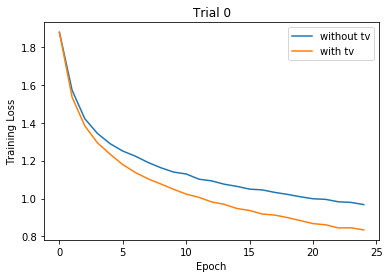

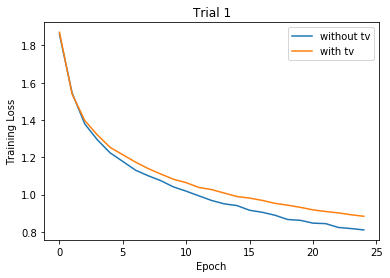

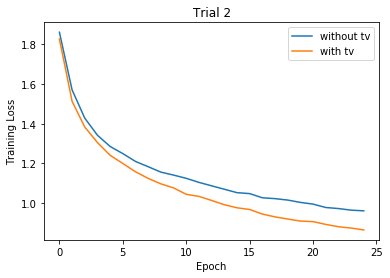

In [57]:
for i in range(3):
    plt.plot(range(25),without_tv[i]['losses'], label="without tv")
    plt.plot(range(25),with_tv[i]['losses'], label = "with tv")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Trial " + str(i))
    plt.show()

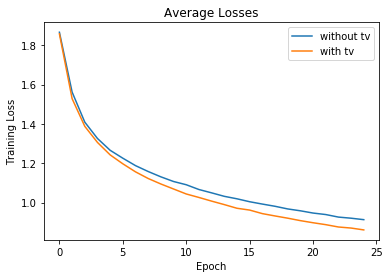

In [58]:
plt.plot(range(25),[(a+b+c)/3 for a,b,c in zip(*[without_tv[i]['losses'] for i in range(3)])], label="without tv")
plt.plot(range(25),[(a+b+c)/3 for a,b,c in zip(*[with_tv[i]['losses'] for i in range(3)])], label = "with tv")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Average Losses")
plt.show()

### Validation Losses

In [ ]:
for i in range(3):
    plt.plot(range(25),without_tv[i]['val_losses'], label="without tv")
    plt.plot(range(25),with_tv[i]['val_losses'], label = "with tv")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Trial " + str(i))
    plt.show()